# News Articles Categorization
**Thomas Bohn**   --   **2023-09-08**

A report focused on modeling news artical categorization for BBC News focused on the application of natural language processing, unsupervised learning with matrix factorization, and a comparison to supervised learning.

--  [Main Report](https://github.com/TOM-BOHN/MsDS-news-articles-categorization/blob/main/news-articles-categorization.ipynb)  --  [Github Repo](https://github.com/TOM-BOHN/MsDS-news-articles-categorization)  --  [Presentation Slides](TBD)  --  [Presentation Video](TBD) --

# 1.&nbsp;Introduction

**Background**
Text documents are one of the richest sources of data for businesses. By using Natural Language Processing (NLP) features can be created for supervised and unsupervised models. Unsupervised models are typically better at handling the larve volume of features created from text documents. [1]

**Data Source**
Use a public dataset from the BBC comprised of 2225 articles. More details on the datasource can be found here: [learn ai bbc](https://www.kaggle.com/competitions/learn-ai-bbc/overview) [1]. 


**Categories**
The articles are labeled under one of 5 categories:
- business
- entertainment
- politics
- sport
- tech

**Overview of Observations**
The dataset is broken into 1490 records for training and 735 for testing. Each observation is the full text of the article with an associated article id [1]. The text files need to be broaken out into features. The training dataset indicates the category. No category is provided for the test dataset.

**Objective**
The objective is to build an unsupervised Non-Negative Matrix Factorization (NMF) model. The model should be capable of accurately classify previously unseen news articles into one of the five categories. FInal evaluation will use Accuracy as a metric.

**Report Overview**
The project will cover 5 key phases:
1. Exploratory Data Analysis (EDA)
2. Data Cleaning
3. Extracting Word Features with Natural Language Processing (MLP) Tools
4. Building and Training an Unsupervised Non-Negative Matrix Factorization (NMF) Model
5. Build and Compare a Random Forest Supervised Learning Model

## Python Libraries

The following python libraries are used in this notebook.

In [1]:
# File Connection and File Manipulation
import os
# from google.colab import drive

# Basic Data Science Toolkits
import pandas as pd
import numpy as np
import math
import time
import itertools as it

# Data Vizualization
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib import ticker
import seaborn as sns

# Text Mining
import string
from textblob import TextBlob


#NLP Text Cleanup
import re
import nltk
import nltk.corpus
from nltk.corpus import stopwords

# NLP Tokenizer and Lemmatizer
import nltk
import nltk.corpus
from nltk.corpus import wordnet
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from string import digits

# Feature Engineering
import sklearn
from sklearn.feature_extraction.text import TfidfVectorizer

#Data Model Unsupervised NFM
import sklearn
from sklearn.decomposition import NMF

# Data Models Unsupervised RF
import sklearn
from sklearn.ensemble import RandomForestClassifier

# Import Data Model Evaluations
from sklearn.model_selection import train_test_split

# Cross Validation, Grid Search, and K-Fold
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold


#from sklearn.datasets import make_classification
#from sklearn.metrics import make_scorer

# Data Model Scores
#from sklearn.metrics import roc_auc_score
#from sklearn.metrics import accuracy_score
#from sklearn.metrics import precision_score
#from sklearn.metrics import recall_score
#from sklearn.metrics import f1_score
#from sklearn.metrics import roc_curve

#Data Model Unsupervised SVD
#import sklearn
#from sklearn.decomposition import TruncatedSVD

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Installing NLTK Data

In [2]:
#Install the necessary datasets/models for specific functions to work
nltk.download('popular', quiet=True)
# Test to confirm the download worked
from nltk.corpus import brown
brown.words()
#dir(nltk)

['The', 'Fulton', 'County', 'Grand', 'Jury', 'said', ...]

In [3]:
# unzip the wordnet file as a workaround for a bug
!unzip -q -o /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/
# verify that paths exist
#!ls /usr/share/nltk_data/corpora
print(nltk.find('corpora'))
print(nltk.find('corpora/wordnet'))

/usr/share/nltk_data/corpora
/usr/share/nltk_data/corpora/wordnet


## Global Variables

The following are global variables referenced in this notebook.

In [4]:
# Global Debug flag used to turn on and off more chatty blocks of code
gDEBUG = False
if gDEBUG: print('Debug is set to:', gDEBUG)
# Global Level of Detail of table stats and details
gLOD = 2
print('Level of Detail for functions is set to:', gLOD)

Level of Detail for functions is set to: 2


# 2.&nbsp;Data Source

In [5]:
# Input data files are available in the read-only "../input/" directory
# List all files under the input directory
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/learn-ai-bbc/BBC News Train.csv
/kaggle/input/learn-ai-bbc/BBC News Sample Solution.csv
/kaggle/input/learn-ai-bbc/BBC News Test.csv


In [6]:
#label file paths
path_dir = '/kaggle/input/learn-ai-bbc/'
train_path = path_dir + 'BBC News Train.csv'
test_path = path_dir + 'BBC News Test.csv'
sample_solution_path = path_dir + 'BBC News Sample Solution.csv'

In [7]:
#import data
df_train = pd.read_csv(train_path)
df_test = pd.read_csv(test_path)
df_sample_solution = pd.read_csv(sample_solution_path)

#assign names to tables
df_train.name = 'df_train'
df_test.name = 'df_test'
df_sample_solution.name = 'df_sample_solution'

In [8]:
# Create a function to print key table details
def quick_table_details (df_name, df, level_of_detail = 10):
  # describe the shape and column summary
  if level_of_detail >= 1:
    print('\n####', df_name, '####')
    num_rows = df.shape[0]
    num_cols = df.shape[1]
    print('number of features (columns) = ' + str(num_cols))
    print('number of observations (rows) = ' + str(num_rows))
    print('----------------------------', '\n')
  # print the datatype counts
  if level_of_detail >= 2:
    print('DataType Counts:')
    print(df.dtypes.value_counts())
    print('----------------------------', '\n')
  # print a full list of column names
  if level_of_detail >= 3:
    print('Columns:')
    print(df.columns)
    print('----------------------------', '\n')
  #  expanded table details
  if level_of_detail >= 4:
    print('Description:')
    print(df.describe(include='all'))
    print('----------------------------', '\n')
    print('Info:')
    print(df.info())
    print('----------------------------', '\n')
  #  table records preview
  if level_of_detail >= 5:
    print('Table Preview:')
    x_records = 3
    print(df.head(x_records))
    print('....')
    print(df.tail(x_records))
    print('----------------------------', '\n')
        

In [9]:
# Print summary details for the 3 tables in the datasource
quick_table_details (df_train.name, df_train, level_of_detail = 10)
quick_table_details (df_test.name, df_test, level_of_detail = 10)
quick_table_details (df_sample_solution.name, df_sample_solution, level_of_detail = 10)


#### df_train ####
number of features (columns) = 3
number of observations (rows) = 1490
---------------------------- 

DataType Counts:
object    2
int64     1
dtype: int64
---------------------------- 

Columns:
Index(['ArticleId', 'Text', 'Category'], dtype='object')
---------------------------- 

Description:
          ArticleId                                               Text  \
count   1490.000000                                               1490   
unique          NaN                                               1440   
top             NaN  microsoft seeking spyware trojan microsoft is ...   
freq            NaN                                                  2   
mean    1119.696644                                                NaN   
std      641.826283                                                NaN   
min        2.000000                                                NaN   
25%      565.250000                                                NaN   
50%     1112.50000

# 3.&nbsp;Exploratory Data Analysis (EDA)

When exploring the data, the following explorations will be conducted:
- Review the distribution of categories
- Review the distribution of charecters in each article
- Review the distribution of words in each article

## Review the Distribution of Categories

In [10]:
#print column names for each table
print('columns in df_train:', df_train.columns)
print('columns in df_test:', df_test.columns)
print('columns in df_sample_solution:', df_sample_solution.columns)

columns in df_train: Index(['ArticleId', 'Text', 'Category'], dtype='object')
columns in df_test: Index(['ArticleId', 'Text'], dtype='object')
columns in df_sample_solution: Index(['ArticleId', 'Category'], dtype='object')


In [11]:
# function to count the number of records in each category and stats
def count_field(df, field = 'Category'):
    df_cat_count = pd.DataFrame(df[field].value_counts()).reset_index()
    df_cat_count = df_cat_count.rename(columns={'Category': 'Count', 'index': 'Category'})
    df_cat_count = df_cat_count.sort_values(by = ['Count'], ascending = False)
    df_cat_count['Pct of Total'] = round(df_cat_count['Count'] / df_cat_count['Count'].sum(), 2)
    df_cat_count['Pct of Total Text'] = (df_cat_count['Pct of Total'] * 100).apply(int).apply(str) + ' %'
    return df_cat_count

In [12]:
# calculate the count of records in each category
df_cat_count_train = count_field(df = df_train, field = 'Category')
df_cat_count_df_sample_solution = count_field(df = df_sample_solution, field = 'Category')

print(df_cat_count_train)

        Category  Count  Pct of Total Pct of Total Text
0          sport    346          0.23              23 %
1       business    336          0.23              23 %
2       politics    274          0.18              18 %
3  entertainment    273          0.18              18 %
4           tech    261          0.18              18 %


In [13]:
# define a function to aggregate dataframe on a single category
def shape_df_for_stacked_barchart(df, group_by, stack_by, normalize=True):
  df_chart = (df
              .groupby(group_by)[stack_by]
              .value_counts(normalize = normalize)
              .round(2)
              .unstack())
  return df_chart

# defgine a function to plot a bar chart for a single category
def create_single_stacked_bar(df, group_by, stack_by, fig_size = (5,5), normalize=True):
  df_chart = shape_df_for_stacked_barchart(df = df, group_by = group_by, stack_by = stack_by, normalize = normalize)
  if gDEBUG: print(df_chart, '\n')
  fig, ax = plt.subplots(figsize = fig_size)
  # plot the chart
  chart = df_chart.plot.bar(stacked = True,
                    ax = ax,
                    width = 0.3,
                    edgecolor = "black")
  # Customising legend
  ax.legend(fontsize = 10, title_fontsize = 10)

  ax.set_title(group_by, fontsize=10)
  ax.set_xlabel(group_by, fontsize=8)
  ax.set_ylabel('Record Count', fontsize=8)
  return fig

[-] the catgory of sport makes up 23 % of the data.
[-] the catgory of business makes up 23 % of the data.
[-] the catgory of politics makes up 18 % of the data.
[-] the catgory of entertainment makes up 18 % of the data.
[-] the catgory of tech makes up 18 % of the data.


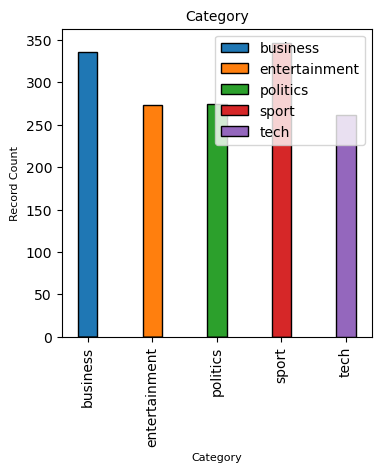

In [14]:
# Summarize the target in the dataset
chart = create_single_stacked_bar(df = df_train, group_by = 'Category', stack_by = 'Category', fig_size = (4,4), normalize = False)
table = shape_df_for_stacked_barchart(df = df_train, group_by = 'Category', stack_by = 'Category', normalize = False)
# Print a summary of the percent share of the total for each category
for i in range(len(df_cat_count_train)):
    print('[-] the catgory of', df_cat_count_train['Category'].iloc[i], 'makes up',
           df_cat_count_train['Pct of Total Text'].iloc[i], 'of the data.')

Overall the data is evenly split between categories. There is between 18% and 23% of the data in each category. No additional work will be done to balance the records in these categories.

## Review of the Text

Text(0, 0.5, 'Record Count')

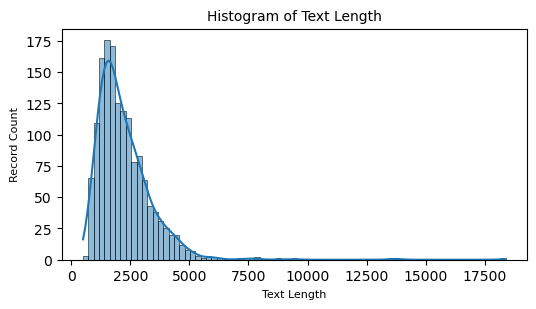

In [15]:
# add a length column to the dataframe
df_train['Text Length'] = df_train['Text'].apply(len)
#create a figure
fig, ax = plt.subplots(figsize = (6,3))
# create a histogram of the length of text
#chart = plt.hist(x = df_s['Text Length'])
chart = sns.histplot(x = df_train['Text Length'], kde=True)
# Customising legend
ax.set_title('Histogram of Text Length', fontsize=10)
ax.set_xlabel('Text Length', fontsize=8)
ax.set_ylabel('Record Count', fontsize=8)

There is a slight skew to the the lenght of the articles with a long tail extending up to some very large values. Further analysis should be conducted to determine if there are outliers.

Text(0.5, 1.0, 'Boxplot of Text Length')

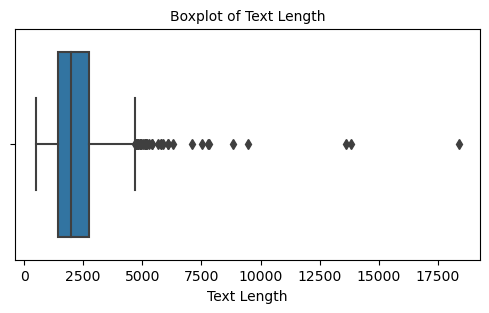

In [16]:
# add a length column to the dataframe
df_train['Text Length'] = df_train['Text'].apply(len)
df_test['Text Length'] = df_test['Text'].apply(len)
#create a figure
fig, ax = plt.subplots(figsize = (6,3))
# create a boxplot of the length of text
chart = sns.boxplot(x = df_train['Text Length'])
ax.set_title('Boxplot of Text Length', fontsize=10)

Reviewing a box plot, it is clear that many articles are candidates for outliers. A cutoff point will need to be identified, and outlier articles on length can be considered for dropping in the data cleansing steps.

Text(0.5, 1.0, 'Boxplot of Word Count')

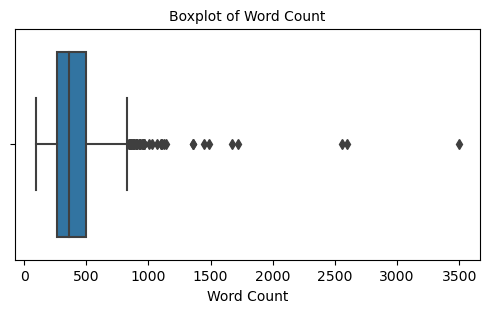

In [17]:
# define a function to add the word count to a dataframe
def add_word_count(df):
    df['Text Tokens'] = df.apply(lambda row: nltk.word_tokenize(row['Text']), axis=1)
    df['Word Count'] = df['Text Tokens'].apply(len)
    df.drop(columns = ['Text Tokens'], inplace=True)
    return df
# add a length column to the dataframe for wordcount
df_train = add_word_count(df = df_train)
df_test = add_word_count(df = df_test)
#create a figure
fig, ax = plt.subplots(figsize = (6,3))
# create a boxplot of the length of text
chart = sns.boxplot(x = df_train['Word Count'])
ax.set_title('Boxplot of Word Count', fontsize=10)

Revieweing the wordcount, we see a similar pattern displayed. Again, we should consider removing some the outlier values with large word counts relative the rest of the articles.

In [18]:
# show the content of one Article in the data source
print(df_train['Text'][0])

worldcom ex-boss launches defence lawyers defending former worldcom chief bernie ebbers against a battery of fraud charges have called a company whistleblower as their first witness.  cynthia cooper  worldcom s ex-head of internal accounting  alerted directors to irregular accounting practices at the us telecoms giant in 2002. her warnings led to the collapse of the firm following the discovery of an $11bn (£5.7bn) accounting fraud. mr ebbers has pleaded not guilty to charges of fraud and conspiracy.  prosecution lawyers have argued that mr ebbers orchestrated a series of accounting tricks at worldcom  ordering employees to hide expenses and inflate revenues to meet wall street earnings estimates. but ms cooper  who now runs her own consulting business  told a jury in new york on wednesday that external auditors arthur andersen had approved worldcom s accounting in early 2001 and 2002. she said andersen had given a  green light  to the procedures and practices used by worldcom. mr ebbe

The text included in the article field appears to be unformatted article text. It includes punctuation, common articles and connecting words, and conjugated or derivatives of a base word. The text will need to be cleansed to ensure it is prepared for modeling. An effort should be made to remove articles and punctuation that could add noise to the model. Words should be simplified to their base forms to ensure they can be properly matched.

## Results of EDA

After completing the initial exploratory data analysis and details related to the table, there are several data cleansing activities that could potentially improve data source. These include:
- Data type munging
- Checking for null values
- Cleaning the Text field that describes the article
- Remove any outliers based on word count or article length
- Lemmatization of the text

# 4.&nbsp;Data Cleansing

Data cleaning identified in the exploratory data analysis will be executed in this section.

## Data Type Munging

In [19]:
# convert a list of fields to a specific datatype
def convert_dtype_basic(df, data_type, col_list, LOD = 10):
  print('## Updating the datatypes in dataframe =', df.name,'##')
  for field in col_list:
    if field in df.columns:
      # drop the fields
      df[field] = df[field].astype(data_type)
      print('[-]', 'field =', field, 'change to datatype =', data_type)
    else:
      # display a message that the drop did not work
      print('[!]', 'field =', field, 'is not in the DataFrame.')
  print()
  return df

# create a function to review how many fields still need to be mapped to a datatype
def dtype_review_update(df, completed_list):
  all_cols = df.columns
  remaining_cols = set(all_cols)
  # remove any field on the completed list from the remaining col list
  for i in range(len(completed_list)):
    remaining_cols = remaining_cols - set(completed_list[i])
  remaining_cols = list(remaining_cols)

  #Pritn a summary of columns remaining
  print('There are', len(remaining_cols), 'columns to still map.')
  print('List of remaining columns:', remaining_cols)
  print()
  if gDEBUG: print(df_s.dtypes[remaining_cols])
  if gDEBUG: print()

  return remaining_cols
    
# display a summary message once the datatype mapping is completed
def dtype_update_completed(df, dtype_list, completed_list):
  df_dtype_count = df.dtypes.value_counts()
  #print(df_dtype_count)
  print('Completed update of data type for', len(df.columns), 'columns.')
  for i in range(df_dtype_count.shape[0]):
      print('-- Corrected or validated data type for', df_dtype_count.iloc[i], list(df_dtype_count.index)[i], 'columns.')
  print()
  if gDEBUG: print(df.info())
  if gDEBUG: print('')

In [20]:
# Convert String, Categoriy fields
str_cols = ['ArticleId', 'Text']
cat_cols = ['Category']
# df_train
df_train = convert_dtype_basic(df = df_train, data_type = 'object', col_list = str_cols)
df_train = convert_dtype_basic(df = df_train, data_type = 'category', col_list = cat_cols)
# df_test
df_test = convert_dtype_basic(df = df_test, data_type = 'object', col_list = str_cols)
df_test = convert_dtype_basic(df = df_test, data_type = 'category', col_list = cat_cols)
# df_sample_solution
df_sample_solution = convert_dtype_basic(df = df_sample_solution, data_type = 'object', col_list = str_cols)
df_sample_solution = convert_dtype_basic(df = df_sample_solution, data_type = 'category', col_list = cat_cols)

# check the progress of datatype mapping
completed_list = [str_cols, cat_cols]
# there should be no fields left to map
fields_to_review = dtype_review_update(df = df_train, completed_list = completed_list)
fields_to_review = dtype_review_update(df = df_test, completed_list = completed_list)
fields_to_review = dtype_review_update(df = df_sample_solution, completed_list = completed_list)

# display a the datatype mapping complete message and summary
dtype_list = ['string', 'category']
dtype_update_completed(df = df_train, dtype_list = dtype_list, completed_list = completed_list)
dtype_update_completed(df = df_test, dtype_list = dtype_list, completed_list = completed_list)
dtype_update_completed(df = df_sample_solution, dtype_list = dtype_list, completed_list = completed_list)

## Updating the datatypes in dataframe = df_train ##
[-] field = ArticleId change to datatype = object
[-] field = Text change to datatype = object

## Updating the datatypes in dataframe = df_train ##
[-] field = Category change to datatype = category

## Updating the datatypes in dataframe = df_test ##
[-] field = ArticleId change to datatype = object
[-] field = Text change to datatype = object

## Updating the datatypes in dataframe = df_test ##
[!] field = Category is not in the DataFrame.

## Updating the datatypes in dataframe = df_sample_solution ##
[-] field = ArticleId change to datatype = object
[!] field = Text is not in the DataFrame.

## Updating the datatypes in dataframe = df_sample_solution ##
[-] field = Category change to datatype = category

There are 2 columns to still map.
List of remaining columns: ['Word Count', 'Text Length']

There are 2 columns to still map.
List of remaining columns: ['Word Count', 'Text Length']

There are 0 columns to still map.
List of re

## Check for Null Values

In [21]:
# Inspect observations (rows) with null values
def count_all_rows_with_null(df):
  df_null = df.isnull()
  df_null['null_count'] = df_null.sum(axis=1)
  df_null['null_flag'] = df_null['null_count'].apply(lambda x: 1 if x > 0 else 0)

  df_null = df_null[df_null['null_count'] > 0]
  print(df.name, 'count of observations with nulls:',df_null['null_flag'].sum())

In [22]:
# Count all null records
count_all_rows_with_null(df = df_train)
count_all_rows_with_null(df = df_test)
count_all_rows_with_null(df = df_sample_solution)

df_train count of observations with nulls: 0
df_test count of observations with nulls: 0
df_sample_solution count of observations with nulls: 0


## Clean Text for Modeling

In [23]:
# Create a funtion to clean a dataframe with text
def clean_text(df, text_col):
    # removes punctuation
    df['no_punct'] = df[text_col].apply(
        lambda row: re.sub(r'[^\w\s]+', '', row))
    # removes numbers
    df['no_punct_num'] = df['no_punct'].apply(
        lambda row: re.sub(r'[0-9]+', '', row))
    # removes stop words, e.g. a, an, and, but, in, on, the...
    stop_words = stopwords.words('english')
    df['no_stopwords'] = df['no_punct_num'].apply(
        lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))
    # removes extra spaces
    df['Clean Text'] = df['no_stopwords'].apply(
        lambda x: re.sub(' +', ' ', x))
    return

In [24]:
# add a length column to the dataframe
df_train['Text Length'] = df_train['Text'].apply(len)
df_test['Text Length'] = df_test['Text'].apply(len)

# Using 'clean_text' function to clean 'Text' column
clean_text(df = df_train, text_col = 'Text')
clean_text(df = df_test, text_col = 'Text')
df_train.head()

,ArticleId,Text,Category,Text Length,Word Count,no_punct,no_punct_num,no_stopwords,Clean Text
0,1833,worldcom ex-boss launches defence lawyers defe...,business,1866,316,worldcom exboss launches defence lawyers defen...,worldcom exboss launches defence lawyers defen...,worldcom exboss launches defence lawyers defen...,worldcom exboss launches defence lawyers defen...
1,154,german business confidence slides german busin...,business,2016,342,german business confidence slides german busin...,german business confidence slides german busin...,german business confidence slides german busin...,german business confidence slides german busin...
2,1101,bbc poll indicates economic gloom citizens in ...,business,3104,544,bbc poll indicates economic gloom citizens in ...,bbc poll indicates economic gloom citizens in ...,bbc poll indicates economic gloom citizens maj...,bbc poll indicates economic gloom citizens maj...
3,1976,lifestyle governs mobile choice faster bett...,tech,3618,670,lifestyle governs mobile choice faster bett...,lifestyle governs mobile choice faster bett...,lifestyle governs mobile choice faster better ...,lifestyle governs mobile choice faster better ...
4,917,enron bosses in $168m payout eighteen former e...,business,2190,382,enron bosses in 168m payout eighteen former en...,enron bosses in m payout eighteen former enron...,enron bosses payout eighteen former enron dire...,enron bosses payout eighteen former enron dire...


In [25]:
# Preview the changes for the before and after text
print(df_train['Text'][0])
print('\n## change to ##\n')
print(df_train['Clean Text'][0])

worldcom ex-boss launches defence lawyers defending former worldcom chief bernie ebbers against a battery of fraud charges have called a company whistleblower as their first witness.  cynthia cooper  worldcom s ex-head of internal accounting  alerted directors to irregular accounting practices at the us telecoms giant in 2002. her warnings led to the collapse of the firm following the discovery of an $11bn (£5.7bn) accounting fraud. mr ebbers has pleaded not guilty to charges of fraud and conspiracy.  prosecution lawyers have argued that mr ebbers orchestrated a series of accounting tricks at worldcom  ordering employees to hide expenses and inflate revenues to meet wall street earnings estimates. but ms cooper  who now runs her own consulting business  told a jury in new york on wednesday that external auditors arthur andersen had approved worldcom s accounting in early 2001 and 2002. she said andersen had given a  green light  to the procedures and practices used by worldcom. mr ebbe

In [26]:
# Create a funtion to remove temp columns and track text changes
def clean_text_columns(df):
    # Update the Old or Prior Values
    df['Text Length (Old)'] = df['Text Length']
    df['Word Count (Old)'] = df['Word Count']
    # Calculate the New Values
    df['Text'] = df['Clean Text']
    df['Text Length'] = df['Text'].apply(len)
    df['Text Tokens Temp'] = df.apply(lambda row: nltk.word_tokenize(row['Text']), axis=1)
    df['Word Count'] = df['Text Tokens Temp'].apply(len)
    df.drop(columns = ['Text Tokens Temp'], inplace=True)
    df.drop(columns = ['no_punct','no_punct_num','no_stopwords', 'Clean Text'], inplace=True)
    
    return

In [27]:
# Remove temp columns from the dataframes and keep them tidy
clean_text_columns(df = df_train)
clean_text_columns(df = df_test)
df_train.head()

,ArticleId,Text,Category,Text Length,Word Count,Text Length (Old),Word Count (Old)
0,1833,worldcom exboss launches defence lawyers defen...,business,1388,185,1866,316
1,154,german business confidence slides german busin...,business,1474,194,2016,342
2,1101,bbc poll indicates economic gloom citizens maj...,business,2061,267,3104,544
3,1976,lifestyle governs mobile choice faster better ...,tech,2381,344,3618,670
4,917,enron bosses payout eighteen former enron dire...,business,1517,198,2190,382


## Remove Outliers Based on Text Length

In [28]:
# function to identify outliers and remove them 
def remove_outliers(df):
    # IQR
    Q1 = np.percentile(df['Word Count'], 25, method='midpoint')
    Q3 = np.percentile(df['Word Count'], 75, method='midpoint')
    IQR = Q3 - Q1
    print('Q1: ', int(round(Q1,0)))
    print('Q3: ', int(round(Q3,0)))
    print('IQR:', int(round(IQR,0)))
    print()

    # Above Upper bound
    upper_limit = int(Q3 + (1.5 * IQR))
    upper_array = np.where(df['Word Count'] >= upper_limit)[0]
    print("Upper Bound:",upper_limit)
    print('Upper Bound Outlier Count:', len(upper_array))
    print('Upper Bound Outlier List:', upper_array)
    print()

    #Below Lower bound
    lower_limit = int(Q1 - (1.5 * IQR))
    lower_array = np.where(df['Word Count'] <= lower_limit)[0]
    print('Lower Bound:', lower_limit)
    print('Lower Bound Outlier Count:', len(lower_array))
    print('Lower Bound Outlier List:', lower_array)
    print()

    # Remove the outliers
    print('Old Shape:', df.shape)
    old_rec_count = df.shape[0]
    df.drop(index=upper_array, inplace=True)
    df.drop(index=lower_array, inplace=True)
    new_rec_count = df.shape[0]
    
    #Print summary of the action taken and the final result
    print('Dropped', round((((old_rec_count - new_rec_count) / old_rec_count) * 100), 2), '% of the records.')
    print('New Shape:', df.shape)
    
    return df

In [29]:
# Remove outliers from the dataset
df_train = remove_outliers(df = df_train)
# don't remove outliers from the test dataset as we need a result for all records

Q1:  139
Q3:  262
IQR: 122

Upper Bound: 445
Upper Bound Outlier Count: 35
Upper Bound Outlier List: [  26   27   63   88   99  106  120  242  264  279  329  364  372  396
  431  451  454  476  521  565  826  829  893  898  956  987  997 1057
 1122 1167 1258 1371 1417 1439 1464]

Lower Bound: -44
Lower Bound Outlier Count: 0
Lower Bound Outlier List: []

Old Shape: (1490, 7)
Dropped 2.35 % of the records.
New Shape: (1455, 7)


## Lemmatization of Text

Per wikipedia, "Lemmatisation in linguistics is the process of grouping together the inflected forms of a word so they can be analysed as a single item, identified by the word's lemma, or dictionary form." [2] This will be useful in our vectorization as it will begin to standardize different version of the same word to a common representation of the word, resulting in a reduction of linguistic noise in the text documents.

To accomplish this function, the NLTK (Natural Language Toolkit) library will be used. This library "provides easy-to-use interfaces to over 50 corpora and lexical resources such as WordNet, along with a suite of text processing libraries for classification, tokenization, stemming, tagging, parsing, and semantic reasoning, wrappers for industrial-strength NLP libraries." [3] Specifically, we will be using the WordNet Lemmatizer to return the specific lemma defined in WordNet. WordNet is "a lexical database of semantic relations between words that links words into semantic relations" [5] that is commonly used in automatic text analysis and AI applications. It is freely availible for download.

In [30]:
# Tokenize text functions
wordnet_lemmatizer = WordNetLemmatizer()
# Function to bulkify lemmatize large block of text one word at a time
def lemmatizer(text):
    lem = [wordnet_lemmatizer.lemmatize(word.lower()) for word in text] 
    return lem
# Function to tokenize the entire article then apply the lemmatize to each article
def tokenize_lemmatize(dataframe, text_col):
    dataframe['Tokenized Text'] = dataframe.apply(lambda row: nltk.word_tokenize(row[text_col]), axis=1)
    dataframe['Lemmatized Text'] = dataframe['Tokenized Text'].apply(lambda string: lemmatizer(string))
    return

In [31]:
# Using text cleaning function to clean the text column
tokenize_lemmatize(df_train, 'Text')
tokenize_lemmatize(df_test, 'Text')
df_train.head()

,ArticleId,Text,Category,Text Length,Word Count,Text Length (Old),Word Count (Old),Tokenized Text,Lemmatized Text
0,1833,worldcom exboss launches defence lawyers defen...,business,1388,185,1866,316,"[worldcom, exboss, launches, defence, lawyers,...","[worldcom, exboss, launch, defence, lawyer, de..."
1,154,german business confidence slides german busin...,business,1474,194,2016,342,"[german, business, confidence, slides, german,...","[german, business, confidence, slide, german, ..."
2,1101,bbc poll indicates economic gloom citizens maj...,business,2061,267,3104,544,"[bbc, poll, indicates, economic, gloom, citize...","[bbc, poll, indicates, economic, gloom, citize..."
3,1976,lifestyle governs mobile choice faster better ...,tech,2381,344,3618,670,"[lifestyle, governs, mobile, choice, faster, b...","[lifestyle, governs, mobile, choice, faster, b..."
4,917,enron bosses payout eighteen former enron dire...,business,1517,198,2190,382,"[enron, bosses, payout, eighteen, former, enro...","[enron, boss, payout, eighteen, former, enron,..."


In [32]:
# Print a before an after of the tokenization and lematization
print(df_train['Text'][0])
print('\n## change to ##\n')
print(df_train['Lemmatized Text'][0])

worldcom exboss launches defence lawyers defending former worldcom chief bernie ebbers battery fraud charges called company whistleblower first witness cynthia cooper worldcom exhead internal accounting alerted directors irregular accounting practices us telecoms giant warnings led collapse firm following discovery bn bn accounting fraud mr ebbers pleaded guilty charges fraud conspiracy prosecution lawyers argued mr ebbers orchestrated series accounting tricks worldcom ordering employees hide expenses inflate revenues meet wall street earnings estimates ms cooper runs consulting business told jury new york wednesday external auditors arthur andersen approved worldcom accounting early said andersen given green light procedures practices used worldcom mr ebber lawyers said unaware fraud arguing auditors alert problems ms cooper also said shareholder meetings mr ebbers often passed technical questions company finance chief giving brief answers prosecution star witness former worldcom fina

In [33]:
# Create a funtion to remove temp columns and track text changes
def clean_tokenize_lemmatize_columns(df):
    # Update the Old or Prior Values
    df['Text Length (Old)'] = df['Text Length']
    df['Word Count (Old)'] = df['Word Count']
    # Calculate the New Values
    df['Text'] = df.apply(lambda row: ' '.join(row['Lemmatized Text']), axis=1)
    df['Text Length'] = df['Text'].apply(len)
    df['Word Count'] = df['Lemmatized Text'].apply(len)
    # remove any staging fields
    df.drop(columns = ['Tokenized Text'], inplace=True)

    return df

In [34]:
# execute the change trackign columns and cleanup on test and train datasets
df_train = clean_tokenize_lemmatize_columns(df = df_train)
df_test = clean_tokenize_lemmatize_columns(df = df_test)
df_train.head()

,ArticleId,Text,Category,Text Length,Word Count,Text Length (Old),Word Count (Old),Lemmatized Text
0,1833,worldcom exboss launch defence lawyer defendin...,business,1354,185,1388,185,"[worldcom, exboss, launch, defence, lawyer, de..."
1,154,german business confidence slide german busine...,business,1448,194,1474,194,"[german, business, confidence, slide, german, ..."
2,1101,bbc poll indicates economic gloom citizen majo...,business,2006,267,2061,267,"[bbc, poll, indicates, economic, gloom, citize..."
3,1976,lifestyle governs mobile choice faster better ...,tech,2311,344,2381,344,"[lifestyle, governs, mobile, choice, faster, b..."
4,917,enron boss payout eighteen former enron direct...,business,1488,198,1517,198,"[enron, boss, payout, eighteen, former, enron,..."


# 5.&nbsp;Feature Engineering

In this section the text fields will be transformed into matrix form. This will be completed using TfidfVectorizer in the sci-kit learn library. The TfidfVectorizer is equivalent to CountVectorizer followed by TfidfTransformer. In the first step where CountVectorizer is executed, the process the collection of text documents are converted to a sparse matrix of token counts. The result is the creation of feature equivelent to the voaculary size found by analyzing the collection of text documents [7]. In the second step where TfidfTransformer is executed, the full count matrix is transformed to a normalized tf or tf-idf representation. "Tf means term-frequency while tf-idf means term-frequency times inverse document-frequency." [8] The goal of this step is to scale down the impact of tokens that occur with a high frequency in the collection of text documents, focus on more rare tokens with a higher level of information.

In [35]:
# configure the term-frequency times inverse document-frequency model
tfidf = TfidfVectorizer(sublinear_tf = True,
                        stop_words = 'english',
                        ngram_range = (1, 2),
                        min_df = 5,
                        norm = 'l2',
                        encoding = 'latin-1',
                        lowercase = True)

# fit and transform the training dataset
ft_train = tfidf.fit_transform(df_train['Text']).toarray()
print(df_train.name, ':', ft_train.shape)

# fit and transform the testing dataset
ft_test = tfidf.transform(df_test['Text']).toarray()
print(df_test.name, ':', ft_test.shape)

df_train : (1455, 8527)
df_test : (735, 8527)


# 6.&nbsp;Model: Unsupervised: None-Negative Matrix Factorization (NMF)

The unsupervised model used is Non-Negative Matrix Factorization (NMF). This model finds two non-negative matrices, i.e. matrices with all non-negative elements, (W, H) whose product approximates the non-negative matrix X. This factorization can be used for example for dimensionality reduction, source separation or topic extraction. [9] In this project, we will be using it to extract topics, given feature matrix engineered in the prior step.

In [36]:
# Function to predict the topics for a dataset
def predict(w_matrix):
    sortedW = np.argsort(w_matrix)
    n_predictions, maxValue = sortedW.shape
    predictions = [[sortedW[i][maxValue - 1]] for i in range(n_predictions)]
    topics = np.empty(n_predictions, dtype = np.int64)
    for i in range(n_predictions):
        topics[i] = predictions[i][0]
    return topics

In [37]:
#Function to build a map of true labels to predicted labels
def build_label_map(true_label, pred_label, LOD = 0):
    true_label = true_label
    pred_label = pred_label
    n = len(true_label)
    label_map = dict(zip(true_label, pred_label))
    if(LOD >= 1):
        print('label_map :', label_map)
        print('        n :', n, '\n')
    return label_map

#Function to map labels for the label dataframe using the mapping function
def map_label_to_data(label, label_map, LOD = 0):
    df_mapped = label
    df_mapped['mapped_label'] = df_mapped['Category']
    df_mapped = df_mapped.replace({'mapped_label': label_map})
    if(LOD >= 1):
        print(df_mapped)
    return df_mapped

In [38]:
# Foundational true labels, represented as text
true_label_txt = ['business', 'entertainment', 'politics', 'sport', 'tech']

# Function to build the true label text into a true label dictionary
def true_label_mapping(true_label, LOD = 0):
    true_label_num = range(len(true_label_txt))
    if(LOD >= 1):
        print('The true label mapping for the feature data:', '\n')
    true_label_map = build_label_map(true_label = true_label_txt, pred_label = true_label_num, LOD = LOD)
    return true_label_map

true_label_map = true_label_mapping(true_label_txt, LOD = 1)

The true label mapping for the feature data: 

label_map : {'business': 0, 'entertainment': 1, 'politics': 2, 'sport': 3, 'tech': 4}
        n : 5 



In [39]:
# Function to cycle through all potential label mappings and select the best
def label_permute_compare(ytdf, yp, n=5, LOD  = 0):
    """
    ytdf: labels dataframe object
    yp: clustering label prediction output
    Returns permuted label order and accuracy. 
    Example output: (3, 4, 1, 2, 0), 0.74 
    """
    if(LOD >= 1):
        print()
        print('--------------------------------')
    # Create a df with the matched label and predicted label
    df_tvp = pd.DataFrame()
    df_tvp['ytdf'] = ytdf.iloc[:, 0]
    df_tvp['yp'] = yp
    df_tvp['record_count'] = 1
    # Create a flag for each label based on the specific n (wide table)
    for i in range(5):
        df_tvp[i] = (df_tvp['yp'] == i)
    # Drop the predicted label that makes the table skinny
    df_tvp = df_tvp.drop(['yp'], axis=1)
    # Display the raw table for mapping
    def print_wide_df(df):
        print()
        print('wide df display:')
        print(df.head())
        print('...')
        print(df.tail())
    #print_wide_df(df = df_tvp)
    
    # Summerize the table based on the true label
    df_agg = df_tvp.groupby(['ytdf']).agg('sum')
    df_agg = df_agg.reset_index()
    # Select the winning label and the count of the winning label
    df_agg['py_map'] = df_agg.apply(lambda row: dict(zip(range(len(row.iloc[2:])), row.iloc[2:])), axis = 1)
    ytdf_order = df_agg['ytdf']
    df_agg.insert(1, 'ytdf_order', ytdf_order)
    df_agg = df_agg.replace({'ytdf_order': true_label_mapping(true_label_txt, LOD = LOD)})
    df_agg.insert(3, 'py', None)
    df_agg.insert(4, 'py_count', None)
    df_agg.insert(5, 'py_acc', None)
    df_agg = df_agg.sort_values(by = 'ytdf_order')
    # Display the summary table for mapping
    def print_summary_df(df):
        print('\n', 'summary df display:')
        print(df)
        print('\n')
    #if(LOD >= 1): print_summary_df(df = df_agg)

    # build options and test every option perm
    options = list(it.permutations(range(n)))
    # set base case
    acc = 0
    # iterate over options and test for best option
    if(LOD >= 1): print('Optimizing the Label Mapping to Maximize Accuracy:')
    for case in options:
        df_test_temp = df_agg.copy()
        df_test_temp['py'] = list(case)
        df_test_temp['py_count'] = df_test_temp.apply(lambda row: row.iloc[-1][row.iloc[3]], axis = 1)
        df_test_temp['py_acc'] = df_test_temp['py_count'] / df_test_temp['record_count']
        
        # Calculate the final overall accuracy
        total_test = df_test_temp['record_count'].agg('sum')
        match_test = df_test_temp['py_count'].agg('sum')
        acc_test = match_test / total_test
        
        if acc_test > acc:
            # Record the current best overall accuracy
            if(LOD >= 1):
                print('[+] accuracy increased from',
                      '{:.3f}'.format(round(acc, 3)),
                      'to',
                      '{:.3f}'.format(round(acc_test, 3)),
                      'with new label mapping:', case)
            acc = acc_test
            total_obs = total_test
            match_obs = match_test
            # Update the current best mapping and stats
            df_agg = df_test_temp.copy()
            # Create the permuted label order list for the current best
            permuted_label = tuple(df_agg['py'])

    # Display Best Overall Accuracy
    if(LOD >= 1):
        print()
        print('Best Overall Permuted Label Set with Highest Accuracy:')
        print('[.] total          :', total_obs),
        print('[.] matched        :', match_obs),
        print('[.] accuracy       :', round(acc,4))
        print('[.] permuted label :', permuted_label)
        print('--------------------------------', '\n')
    # Display the summary table
    #print_summary_df(df = df_agg)

    #return the label and accuracy
    return permuted_label, acc

In [40]:
# Function to create a confusion matrix and display some supporting details
def display_confusion_matrix(y_true, y_pred, label_map, accuracy, LOD = 0):
    from sklearn.metrics import confusion_matrix
    n = len(label_map)
    cm = confusion_matrix(y_true, y_pred, labels = range(n))
    cf_matrix = pd.DataFrame(cm)
    cf_key = 'key: ' + str(sorted(((v, k) for k, v in label_map.items()), reverse=False))
    
    # Unpack the label dictionary for axis labels
    axis_label = [None] * len(label_map)
    for key, value in label_map.items():
        axis_label[value] = key
    
    # Print the summary and text based details
    if(LOD >= 1):
        print()
        print('## Initial Model ##', '\n')
        print('Accuracy = ', round(accuracy, 4), '\n')
        print('Confusion Matrix (Text)')
        print('\n', cf_key, '\n', '\n', cf_matrix, '\n', sep = '')
        print('Confusion Matrix (Image)')
    
    # Create a visual heatmap
    f = plt.figure(figsize=(4,4))
    plt.subplot(1, 1, 1)
    cm_viz = sns.heatmap(cf_matrix, xticklabels=axis_label, yticklabels=axis_label,
            annot=True, fmt='d', cmap='Blues')
    plt.title("Confusion Matrix")
    plt.xlabel('Predicted Category')
    plt.ylabel('True Category')
    
    return cf_key, cf_matrix

In [41]:
# Creating NMF model and fitting in data
nmf_model = NMF(
    n_components = 5, 
    solver       = 'mu',
    beta_loss    = 'kullback-leibler',
    random_state = 42)

nmf_model.fit(ft_train)

NMF(beta_loss='kullback-leibler', n_components=5, random_state=42, solver='mu')

In [42]:
# Summarize model results
yhat_nmf_train = predict(nmf_model.transform(ft_train))
label_order_nmf_train, accuracy_nmf_train = label_permute_compare(
                                                ytdf = pd.DataFrame(df_train['Category']),
                                                yp   = yhat_nmf_train,
                                                n    = 5,
                                                LOD  = 1)
# Print out the model labels and accuracy
print('Training: Model Accuracy Summary:')
print('Label Order :', label_order_nmf_train)
print('Accuracy    :', round(accuracy_nmf_train,4), '\n')


--------------------------------
The true label mapping for the feature data: 

label_map : {'business': 0, 'entertainment': 1, 'politics': 2, 'sport': 3, 'tech': 4}
        n : 5 

Optimizing the Label Mapping to Maximize Accuracy:
[+] accuracy increased from 0.000 to 0.192 with new label mapping: (0, 1, 2, 3, 4)
[+] accuracy increased from 0.192 to 0.197 with new label mapping: (0, 1, 2, 4, 3)
[+] accuracy increased from 0.197 to 0.243 with new label mapping: (0, 2, 3, 1, 4)
[+] accuracy increased from 0.243 to 0.247 with new label mapping: (0, 2, 4, 1, 3)
[+] accuracy increased from 0.247 to 0.601 with new label mapping: (0, 3, 2, 1, 4)
[+] accuracy increased from 0.601 to 0.638 with new label mapping: (4, 0, 2, 1, 3)
[+] accuracy increased from 0.638 to 0.964 with new label mapping: (4, 3, 2, 1, 0)

Best Overall Permuted Label Set with Highest Accuracy:
[.] total          : 1455
[.] matched        : 1403
[.] accuracy       : 0.9643
[.] permuted label : (4, 3, 2, 1, 0)
------------

label_map : {'business': 4, 'entertainment': 3, 'politics': 2, 'sport': 1, 'tech': 0}
        n : 5 


           Category mapped_label
0          business            4
1          business            4
2          business            4
3              tech            0
4          business            4
...             ...          ...
1485  entertainment            3
1486  entertainment            3
1487       business            4
1488           tech            0
1489           tech            0

[1455 rows x 2 columns]

## Initial Model ## 

Accuracy =  0.9643 

Confusion Matrix (Text)

key: [(0, 'tech'), (1, 'sport'), (2, 'politics'), (3, 'entertainment'), (4, 'business')]

     0    1    2    3    4
0  233    0    2    7    2
1    0  337    1    0    1
2    1    1  266    1    2
3    9    0    2  257    1
4   12    1    8    1  310

Confusion Matrix (Image)


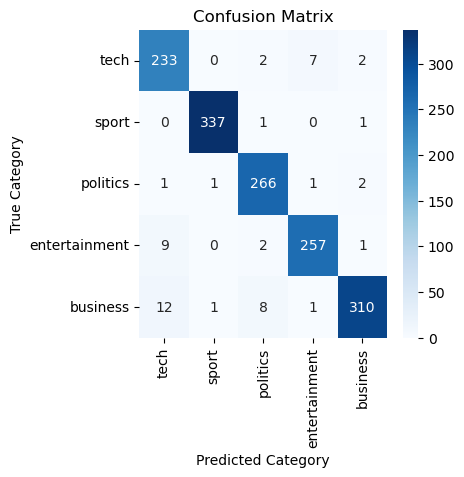

In [43]:
#Map labels to new label numbers
label_map_nmf_train = build_label_map(
                        true_label = true_label_txt,
                        pred_label = label_order_nmf_train,
                        LOD        = 1)
print()
#Map validate labels to new number lables
df_mapped_nmf_train = map_label_to_data(
                        label     = pd.DataFrame(df_train['Category']),
                        label_map = label_map_nmf_train,
                        LOD       = 1)
# Print out summary
cf_key, cf_matrix = display_confusion_matrix(
                        y_true    = df_mapped_nmf_train['mapped_label'],
                        y_pred    = yhat_nmf_train,
                        label_map = label_map_nmf_train,
                        accuracy  = accuracy_nmf_train,
                        LOD       = 1)

## Create Kaggle Submission File


In [44]:
#invert label mapping dictionary
print('label mapping:', label_map_nmf_train)
inv_label_map_nmf_train = {v: k for k, v in label_map_nmf_train.items()}
print('inverted label mapping:', inv_label_map_nmf_train)

label mapping: {'business': 4, 'entertainment': 3, 'politics': 2, 'sport': 1, 'tech': 0}
inverted label mapping: {4: 'business', 3: 'entertainment', 2: 'politics', 1: 'sport', 0: 'tech'}


In [45]:
# Function to predict the training data
def create_test_predictions_nmf(model_type, model, ft_t, df_t):
    yhat_test = predict(model.transform(ft_t))

    #join df_test with predicted labels
    df_test_pred = df_t.copy()
    df_test_pred['Category'] = yhat_test
    df_test_pred.drop(columns = ['Text Length', 'Word Count', 'Text Length (Old)', 'Word Count (Old)', 'Lemmatized Text'], inplace=True)
    df_test_pred.drop(columns = ['Text'], inplace=True)
    
    # save the test results to a csv for sumbission
    dest = '/kaggle/working/' + model_type + '_submission.csv'
    df_test_pred.to_csv(dest, index = False)
    
    return df_test_pred

In [46]:
# Create test data prediction
df_test_nmf_pred = create_test_predictions_nmf(model_type = 'nmf', model = nmf_model,
                                          ft_t = ft_test, df_t = df_test)

In [47]:
# validate file was created
df_saved_file = pd.read_csv('/kaggle/working/nmf_submission.csv')
df_saved_file.head(2)

,ArticleId,Category
0,1018,1
1,1319,0


# 7.&nbsp; Model: Supervised: Random Forest (RF)

In [48]:
# Creating Rsandom Forest model and fitting in data
rf_model = RandomForestClassifier(
              bootstrap = True,
              verbose = 0,
              criterion = 'gini',
              n_estimators = 50,
              max_depth = 10,
              min_samples_leaf = 5,
              max_features = 10
              )

rf_model.fit(ft_train, df_train['Category'])

RandomForestClassifier(max_depth=10, max_features=10, min_samples_leaf=5,
                       n_estimators=50)

In [49]:
# Summarize model results
yhat_rf_train = rf_model.predict(ft_train)
yhat_rf_train = pd.DataFrame(yhat_rf_train, columns = ['Category']).replace({'Category': true_label_map})
yhat_rf_train = np.array(yhat_rf_train)
label_order_rf_train, accuracy_rf_train = label_permute_compare(
                                                ytdf = pd.DataFrame(df_train['Category']),
                                                yp   = yhat_rf_train,
                                                n    = 5,
                                                LOD  = 1)

print('Training: Model Accuracy Summary:')
print('Label Order :', label_order_rf_train)
print('Accuracy    :', round(accuracy_rf_train,4), '\n')


--------------------------------
The true label mapping for the feature data: 

label_map : {'business': 0, 'entertainment': 1, 'politics': 2, 'sport': 3, 'tech': 4}
        n : 5 

Optimizing the Label Mapping to Maximize Accuracy:
[+] accuracy increased from 0.000 to 0.883 with new label mapping: (0, 1, 2, 3, 4)

Best Overall Permuted Label Set with Highest Accuracy:
[.] total          : 1455
[.] matched        : 1285
[.] accuracy       : 0.8832
[.] permuted label : (0, 1, 2, 3, 4)
-------------------------------- 

Training: Model Accuracy Summary:
Label Order : (0, 1, 2, 3, 4)
Accuracy    : 0.8832 



label_map : {'business': 0, 'entertainment': 1, 'politics': 2, 'sport': 3, 'tech': 4}
        n : 5 


           Category mapped_label
0          business            0
1          business            0
2          business            0
3              tech            4
4          business            0
...             ...          ...
1485  entertainment            1
1486  entertainment            1
1487       business            0
1488           tech            4
1489           tech            4

[1455 rows x 2 columns]

## Initial Model ## 

Accuracy =  0.8832 

Confusion Matrix (Text)

key: [(0, 'business'), (1, 'entertainment'), (2, 'politics'), (3, 'sport'), (4, 'tech')]

     0    1    2    3    4
0  326    0    1    5    0
1   23  196    1   49    0
2   16    0  228   24    3
3    0    0    1  338    0
4   27    1    1   18  197

Confusion Matrix (Image)


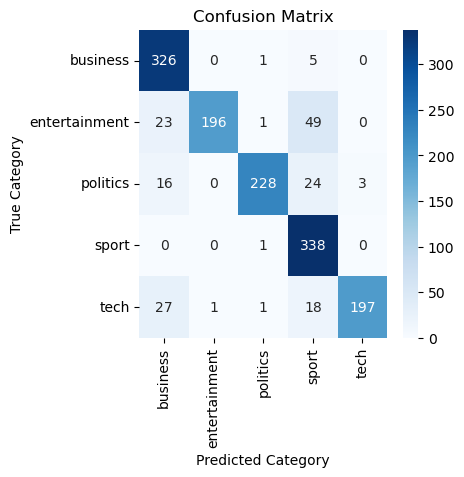

In [50]:
#Map labels to new label numbers
label_map_rf_train = build_label_map(
                        true_label = true_label_txt,
                        pred_label = label_order_rf_train,
                        LOD        = 1)
print()
#Map validate labels to new number lables
df_mapped_rf_train = map_label_to_data(
                        label     = pd.DataFrame(df_train['Category']),
                        label_map = label_map_rf_train,
                        LOD       = 1)

# Print out summary
cf_key, cf_matrix = display_confusion_matrix(
                        y_true    = df_mapped_rf_train['mapped_label'],
                        y_pred    = yhat_rf_train,
                        label_map = label_map_rf_train,
                        accuracy  = accuracy_rf_train,
                        LOD       = 1
)

## Create Kaggle Submission File

In [51]:
#invert label mapping dictionary
print('label mapping:', label_map_rf_train)
inv_label_map_rf_train = {v: k for k, v in label_map_rf_train.items()}
print('inverted label mapping:', inv_label_map_rf_train)

label mapping: {'business': 0, 'entertainment': 1, 'politics': 2, 'sport': 3, 'tech': 4}
inverted label mapping: {0: 'business', 1: 'entertainment', 2: 'politics', 3: 'sport', 4: 'tech'}


In [52]:
# Function to predict the training data
def create_test_predictions(model_type, model, ft_t, df_t):
    yhat_test = model.predict(ft_t)

    #join df_test with predicted labels
    df_test_pred = df_t.copy()
    df_test_pred['Category'] = yhat_test
    df_test_pred.drop(columns = ['Text Length', 'Word Count', 'Text Length (Old)', 'Word Count (Old)', 'Lemmatized Text'], inplace=True)
    df_test_pred.drop(columns = ['Text'], inplace=True)
    
    # save the test results to a csv for sumbission
    dest = '/kaggle/working/' + model_type + '_submission.csv'
    df_test_pred.to_csv(dest, index = False)
    
    return df_test_pred

In [53]:
# Create test data prediction
df_test_rf_pred = create_test_predictions(model_type = 'rf', model = rf_model,
                                          ft_t = ft_test, df_t = df_test)

In [54]:
# validate file was created
df_saved_file = pd.read_csv('/kaggle/working/rf_submission.csv')
df_saved_file.head(2)

,ArticleId,Category
0,1018,sport
1,1319,tech


## Explore Sampling the Data

Discuss comparison with the unsupervised approach.
You may try changing the train data size
(e.g., Include only 10%, 20%, 50% of labels, and observe train/test performance changes).
Which methods are data-efficient
(require a smaller amount of data to achieve similar results)?
What about overfitting?

In [55]:
# get the number of features
total_features = ft_train.shape[1]
print('total features =', total_features)

feature_test_run = []
feature_test_run_pct = []
feature_size_to_test = []

def add_feature_size(step_type, run, pct, size, total, i):
    if step_type == 'int':
        r = len(run) + 1
        s = int(np.floor(i/100*total))
        p = str(int(round(s/total*100,0))).rjust(3) + 'pct'

    elif step_type == 'exp':
        r = len(run) + 1
        s = 2 ** i
        p = str(int(round(s/total*100,0))).rjust(3) + 'pct'
    else:
        print('[!] Error: Bad step type!')
    # add the values to the list
    run.append(r); pct.append(p); size.append(s)
    # display a summary of the values added
    print('test run:', run[-1],
          '\ttest run pct:', pct[-1],
          '\tfeatures to include:', size[-1])


for i in range(1,6,1):
    add_feature_size(step_type = 'exp', i = i,
                     run = feature_test_run,
                     pct = feature_test_run_pct,
                     size = feature_size_to_test,
                     total = total_features)

for i in range(1,10,1):
    add_feature_size(step_type = 'int', i = i,
                     run = feature_test_run,
                     pct = feature_test_run_pct,
                     size = feature_size_to_test,
                     total = total_features)
    
for i in range(10,101,10):
    add_feature_size(step_type = 'int', i = i,
                     run = feature_test_run,
                     pct = feature_test_run_pct,
                     size = feature_size_to_test,
                     total = total_features)

total features = 8527
test run: 1 	test run pct:   0pct 	features to include: 2
test run: 2 	test run pct:   0pct 	features to include: 4
test run: 3 	test run pct:   0pct 	features to include: 8
test run: 4 	test run pct:   0pct 	features to include: 16
test run: 5 	test run pct:   0pct 	features to include: 32
test run: 6 	test run pct:   1pct 	features to include: 85
test run: 7 	test run pct:   2pct 	features to include: 170
test run: 8 	test run pct:   3pct 	features to include: 255
test run: 9 	test run pct:   4pct 	features to include: 341
test run: 10 	test run pct:   5pct 	features to include: 426
test run: 11 	test run pct:   6pct 	features to include: 511
test run: 12 	test run pct:   7pct 	features to include: 596
test run: 13 	test run pct:   8pct 	features to include: 682
test run: 14 	test run pct:   9pct 	features to include: 767
test run: 15 	test run pct:  10pct 	features to include: 852
test run: 16 	test run pct:  20pct 	features to include: 1705
test run: 17 	test 

In [56]:
# a function to execute test predicitons with a variable number of features
def rf_sample_features(model_type, rf_model, ft_x, df_y, ft_t, df_t, n = 100):
    #Randomly sample the features
    ft_x_samp = pd.DataFrame(ft_x).sample(n = n,axis='columns')
    ft_t_samp = pd.DataFrame(ft_t).sample(n = n,axis='columns')
    # Creating Random Forest model and fitting in data
    rf_model = RandomForestClassifier(n_estimators = 100)
    rf_model.fit(ft_x_samp, df_y)
    # Calculate the training accuracy
    rf_acc_train = rf_model.score(ft_x_samp, df_y)
    print('Accuracy :', round(rf_acc_train,4))
    # Create test data prediction
    df_test_rf_pred = create_test_predictions(model_type = model_type, model = rf_model,
                                          ft_t = ft_t_samp, df_t = df_t)
    
    return rf_acc_train

In [57]:
feature_train_acc = []

for (run, pct, size) in zip(feature_test_run, feature_test_run_pct, feature_size_to_test):
    print('[.] run:', run, '\tpct :', pct, '\tfeatures:', size, '\t||\t', end='')
    model_type = 'rf_r' + str(run).zfill(2) + '_s' + str(size).zfill(4)
    acc = rf_sample_features(model_type = model_type, rf_model = rf_model,
                   ft_x = ft_train, df_y = df_train['Category'],
                   ft_t = ft_test, df_t = df_test,
                   n = size)
    feature_train_acc.append(acc)

[.] run: 1 	pct :   0pct 	features: 2 	||	Accuracy : 0.246
[.] run: 2 	pct :   0pct 	features: 4 	||	Accuracy : 0.2584
[.] run: 3 	pct :   0pct 	features: 8 	||	Accuracy : 0.3162
[.] run: 4 	pct :   0pct 	features: 16 	||	Accuracy : 0.3072
[.] run: 5 	pct :   0pct 	features: 32 	||	Accuracy : 0.6089
[.] run: 6 	pct :   1pct 	features: 85 	||	Accuracy : 0.7636
[.] run: 7 	pct :   2pct 	features: 170 	||	Accuracy : 0.9244
[.] run: 8 	pct :   3pct 	features: 255 	||	Accuracy : 0.9856
[.] run: 9 	pct :   4pct 	features: 341 	||	Accuracy : 0.9828
[.] run: 10 	pct :   5pct 	features: 426 	||	Accuracy : 0.9966
[.] run: 11 	pct :   6pct 	features: 511 	||	Accuracy : 0.9966
[.] run: 12 	pct :   7pct 	features: 596 	||	Accuracy : 0.9993
[.] run: 13 	pct :   8pct 	features: 682 	||	Accuracy : 0.9993
[.] run: 14 	pct :   9pct 	features: 767 	||	Accuracy : 1.0
[.] run: 15 	pct :  10pct 	features: 852 	||	Accuracy : 1.0
[.] run: 16 	pct :  20pct 	features: 1705 	||	Accuracy : 1.0
[.] run: 17 	pct : 

In [58]:
# validate file was created
df_saved_file = pd.read_csv('/kaggle/working/rf_r15_s0852_submission.csv')
df_saved_file

,ArticleId,Category
0,1018,business
1,1319,sport
2,1138,business
3,459,business
4,1020,business
...,...,...
730,1923,business
731,373,business
732,1704,sport
733,206,business


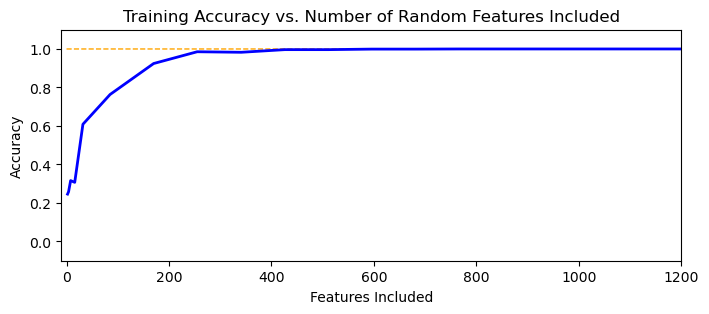

In [59]:
# create figure
fig = plt.figure(figsize=(8,3))
ax = fig.add_subplot(111)
# define x and y
x = feature_size_to_test
y = feature_train_acc
plt.plot(np.arange(0,5000,1),[1] * 5000, color='orange', lw=1, linestyle='--')
plt.plot(x, y, color='blue', lw=2)
plt.xlabel('Features Included')
plt.ylabel('Accuracy')
plt.title('Training Accuracy vs. Number of Random Features Included')
ax.set_xlim([-10, 1200])
ax.set_ylim([-0.1, 1.1])
plt.show()

In [60]:
data = [( 1,   2,0.2259), ( 2,   4,0.2204), ( 3,   8,0.2272), ( 4,  16,0.2626), ( 5,  32,0.2585),
        ( 6,  85,0.2041), ( 7, 170,0.2190), ( 8, 255,0.2095), ( 9, 341,0.2054), (10, 426,0.2367),
        (11, 511,0.2109), (12, 596,0.2122), (13, 682,0.2082), (14, 767,0.2313), (15, 852,0.2313),
        (16,1705,0.2014), (17,2558,0.2027), (18,3410,0.1714), (19,4263,0.4263), (20,5116,0.2354),
       ]
feature_test_acc = pd.DataFrame(data, columns =['run', 'size', 'acc'])

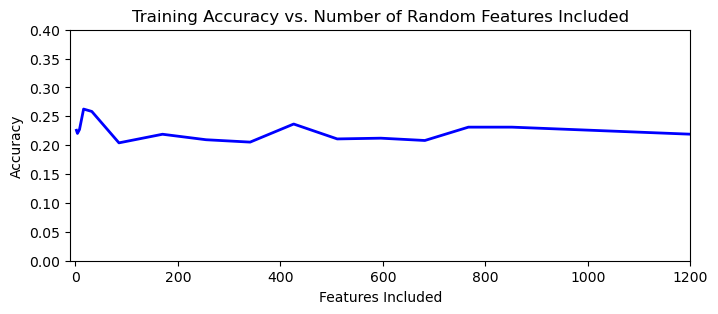

In [61]:
# create figure
fig = plt.figure(figsize=(8,3))
ax = fig.add_subplot(111)
# define x and y
x = feature_test_acc['size']
y = feature_test_acc['acc']
plt.plot(np.arange(0,5000,1),[1] * 5000, color='orange', lw=1, linestyle='--')
plt.plot(x, y, color='blue', lw=2)
plt.xlabel('Features Included')
plt.ylabel('Accuracy')
plt.title('Training Accuracy vs. Number of Random Features Included')
ax.set_xlim([-10, 1200])
ax.set_ylim([0, .4])
plt.show()

## Compare with supervised learning [30 pts]

1) Pick and train a supervised learning method(s) and compare the results (train and test performance)




2) Discuss comparison with the unsupervised approach. You may try changing the train data size (e.g., Include only 10%, 20%, 50% of labels, and observe train/test performance changes).



Which methods are data-efficient (require a smaller amount of data to achieve similar results)? What about overfitting?

# 8.&nbsp; Model Comparison

# 9.&nbsp; Results

# 10.&nbsp; References

**Competition**
- [1] BBC News Classification: News Articles Categorization https://www.kaggle.com/competitions/learn-ai-bbc/overview

**Documentation and References**
- [2] Lemmatization, https://en.wikipedia.org/wiki/Lemmatization
- [3] WordNet, https://en.wikipedia.org/wiki/WordNet
- [4] Natural Language Toolkit (NLTK), https://www.nltk.org/index.html
- [5] nltk.stem.wordnet, https://www.nltk.org/_modules/nltk/stem/wordnet.html
- [6] sklearn.feature_extraction.text.TfidfVectorizer, https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html
- [7] sklearn.feature_extraction.text.CountVectorizer, https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html
- [8] sklearn.feature_extraction.text.TfidfTransformer, https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html#
- [9] sklearn.decomposition.NMF, https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.NMF.html
- [10] 

**Other Kaggle Reports**
- [] Kaggle: bbc article classification https://www.kaggle.com/code/scrambledgabs/bbc-article-classification
- [] Kaggle: BBC News Classification https://www.kaggle.com/code/conradkleykamp/bbc-news-classification#Unsupervised-Model:-Matrix-Factorization-(NMF)
- [] Kaggle: Unsupervised - Matrix Factorization https://www.kaggle.com/code/mattison/unsupervised-matrix-factorization
- [] Kaggle: Make a Classification for BBC News BY LSTM https://www.kaggle.com/code/mohamedbakrey/make-a-classification-for-bbc-news-by-lstm